In [1]:
data_path = '../example-data'
# data_path = 'gs://elife-public-data/sciencebeam/datasets'
dataset_relative_paths = ['pmc-sample-1943-cc-by-subset']
dataset_suffixes = []
tool_names = ['grobid-tei', 'cermine']
# tool_names = ['grobid-tei', 'cermine', 'scienceparse-v1', 'scienceparse-v2']
affiliation_field_names = ['affiliation_strings', 'affiliation_institution']
reference_field_names = [
    'first_reference_fields', 'first_reference_title',
    'reference_fields', 'reference_title', 'reference_year', 'reference_source', 'reference_volume', 'reference_fpage', 'reference_lpage'
]
table_field_names = ['tables', 'table_strings', 'table_labels', 'table_captions', 'table_label_captions']
body_field_names = ['section_titles']
field_names = [
    'title',
    'first_author_full_name', 'author_full_names',
    'abstract'
] + body_field_names + affiliation_field_names + reference_field_names + table_field_names
evaluation_methods = ['levenshtein', 'exact']
summary_filename = 'summary-00000-of-00001.csv'
show_tables = False

# Conversion Results Summary

In [2]:
# This Conversion Results Notebook by default use the very small example dataset
# You may pass in other parameters, e.g.:
#   $papermill conversion-results-tools.ipynb conversion-results-tools-configured.ipynb -p data_path '/my/other/data/path'

In [3]:
%matplotlib inline

In [4]:
import matplotlib
matplotlib.style.use('ggplot')

In [5]:
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import time
import os
import subprocess
import re
import pandas as pd
import matplotlib.pyplot as plt
from markdown import markdown
from IPython.display import display, HTML

warnings.filterwarnings('default')

In [6]:
def parse_list(s):
    if isinstance(s, list):
        return s
    return [x.strip() for x in s.split(',') if x.strip()]

dataset_relative_paths = parse_list(dataset_relative_paths)
tool_names = parse_list(tool_names)
field_names = parse_list(field_names)
evaluation_methods = parse_list(evaluation_methods)
dataset_suffixes = dict(parse_list(dataset_suffixes))

In [7]:
all_result_paths = [
    (
        '%s%s %s' % (dataset_relative_path, dataset_suffix, tool),
        os.path.join(
            data_path,
            '%s-results/evaluation-results/%s%s' % (
                dataset_relative_path,
                tool,
                dataset_suffix
            )
        )
    )
    for dataset_relative_path in dataset_relative_paths
    for dataset_suffix in dataset_suffixes.get(dataset_relative_path, [''])
    for tool in tool_names
]

prefix_list = [
    '%s%s' % (dataset_relative_path, dataset_suffix)
    for dataset_relative_path in dataset_relative_paths
    for dataset_suffix in dataset_suffixes.get(dataset_relative_path, [''])
]

In [8]:
all_result_names = [name for name, _ in all_result_paths]

In [9]:
def printmd(s):
    try:
        s = s.decode('unicode_escape')
    except AttributeError:
        pass
    display(HTML(markdown(s)))

In [10]:
def retrieve_local_copy_if_remote(file_url):
    if file_url.startswith('gs://'):
        local_filename = os.path.join('../.temp', os.path.basename(file_url))
        subprocess.check_output('gsutil cp -P "%s" "%s"' % (file_url, local_filename), shell=True)
        # would be nice if gsutil did actually copy the creation time, let's do it here in a hacky way
        timestamp_match = re.search(r'\s(\d{4}-[^ ]+)\s', subprocess.check_output('gsutil ls -l "%s"' % file_url, shell=True).decode('utf-8'))
        file_time = time.mktime(datetime.strptime(timestamp_match.group(1), "%Y-%m-%dT%H:%M:%SZ").timetuple())
        os.utime(local_filename, (file_time, file_time))
        return local_filename

    return file_url

def load_result_map(all_result_paths, filename):
    df_map = {}
    for name, result_path in all_result_paths:
        full_filename = retrieve_local_copy_if_remote(os.path.join(result_path, filename))
        printmd('**Timestamp:** %s (%s)' % (datetime.fromtimestamp(os.path.getmtime(full_filename)), name))
        df_map[name] = pd.read_csv(full_filename)
        if show_tables:
            display(df_map[name].head(3))
    return df_map

printmd('## Summary Files')
summary_df_map = load_result_map(all_result_paths, summary_filename)

In [11]:
printmd('### Evaluation File States')
printmd('**Evaluation methods:** %s' % ', '.join(sorted(set(
    summary_df_map[all_result_names[0]]['evaluation_method']
))))
printmd('**Field names:** %s' % ', '.join(sorted(set(
    summary_df_map[all_result_names[0]]['field_name'].dropna()
))))

In [12]:
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

,grobid-tei,cermine,scoring_type,evaluation_method
title,0.7,1,string,levenshtein
first_author_full_name,0.7,0.5,string,levenshtein
author_full_names,0.769231,0.527473,partial_set,levenshtein
abstract,0.352941,0.5,string,levenshtein
section_titles,0.47205,0.229885,partial_list,levenshtein
affiliation_strings,0.431373,0.377358,partial_set,levenshtein
affiliation_institution,0.285714,0.226415,partial_set,levenshtein
first_reference_fields,0.7,0.9,list,levenshtein
first_reference_title,0.769231,1,string,levenshtein
reference_fields,0.547315,0.935574,partial_list,levenshtein


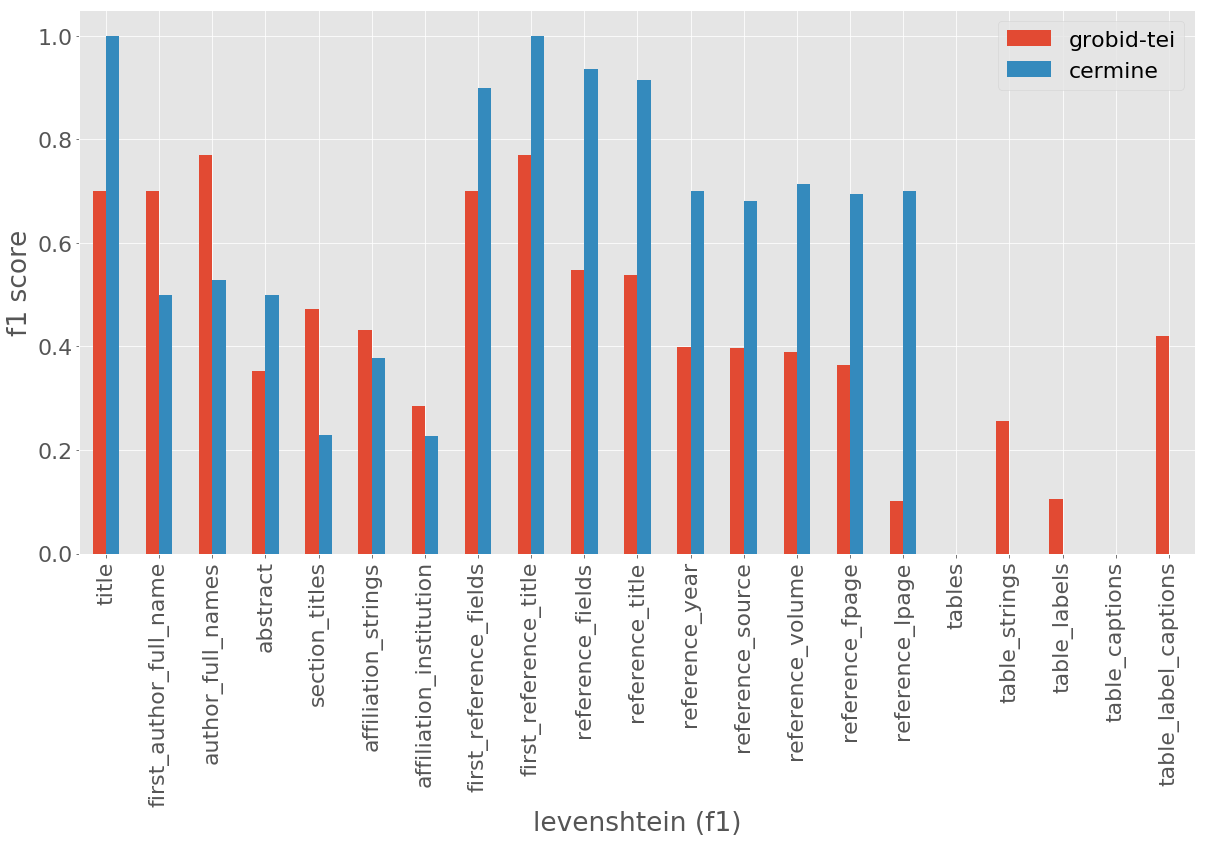

,grobid-tei,cermine,scoring_type,evaluation_method
title,0.6,0.7,string,exact
first_author_full_name,0.7,0.4,string,exact
author_full_names,0.673077,0.417582,partial_set,exact
abstract,0.235294,0.25,string,exact
section_titles,0.459627,0.195402,partial_list,exact
affiliation_strings,0.196078,0.377358,partial_set,exact
affiliation_institution,0.204082,0.188679,partial_set,exact
first_reference_fields,0,0,list,exact
first_reference_title,0.769231,1,string,exact
reference_fields,0.0358056,0.0448179,partial_list,exact


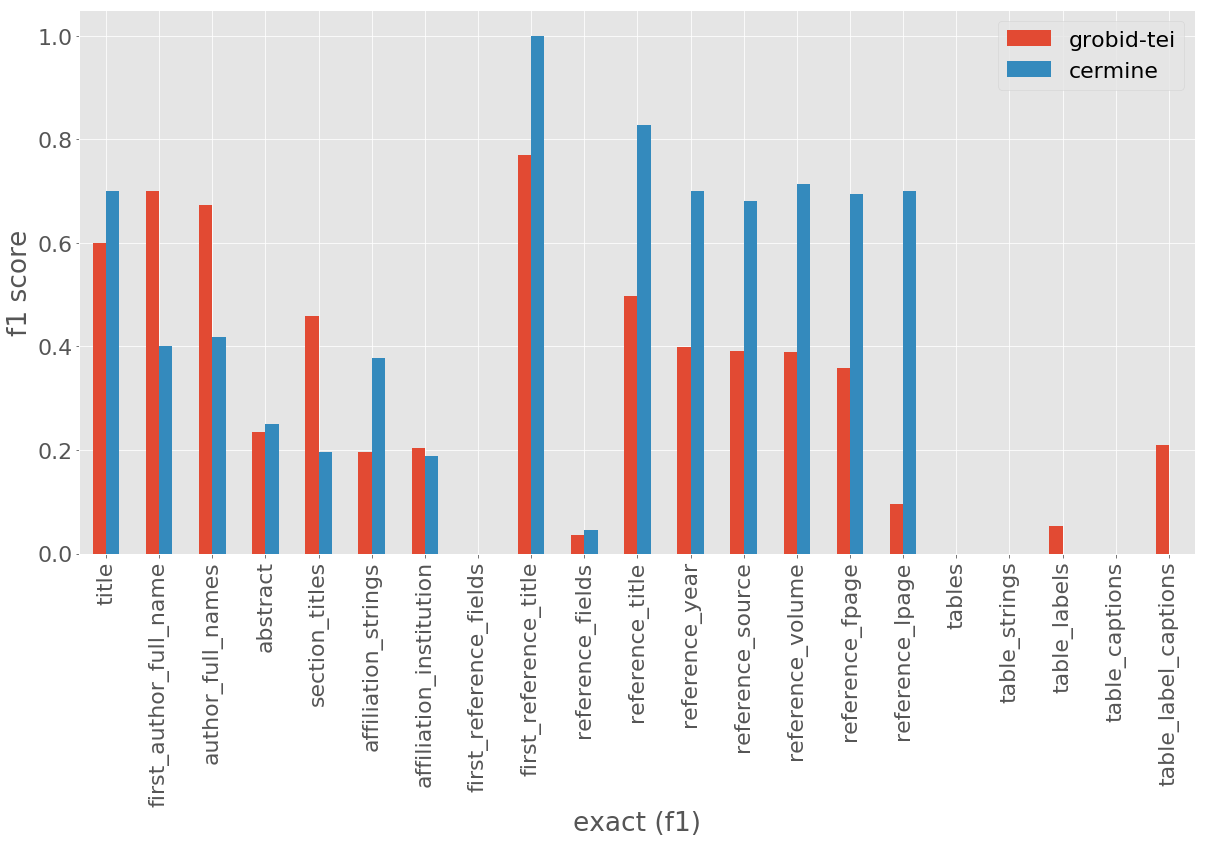

In [13]:
def short_name(full_name):
    return full_name.split(' ')[-1]


def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s[s.apply(pd.np.isreal)].max()
    return ['font-weight: bold' if v else '' for v in is_max]


def show_field_summaries(
        field_summaries_label_and_df, evaluation_method, score_name, field_names,
        table_id):
    def filter_df(df):
        return df[
            (df['evaluation_method'] == evaluation_method) &
            (df['field_name'].isin(field_names))
        ]

    def convert_df(df):
        return df.set_index('field_name')[score_name]

    short_field_summaries_label_and_df = [(short_name(k), df) for k, df in field_summaries_label_and_df]
    field_summaries_df_by_label = dict(short_field_summaries_label_and_df)
    labels = [k for k, _ in short_field_summaries_label_and_df]
    filtered_df_map = {k: filter_df(field_summaries_df_by_label[k]) for k in labels}
    
    field_details_df = pd.concat(
        filtered_df_map.values()
    )[['field_name', 'scoring_type', 'evaluation_method']].groupby(
        'field_name'
    ).agg(lambda l: ', '.join(set(l)))

    field_summary_df = pd.DataFrame({
        k: convert_df(filtered_df_map[k])
        for k in labels
    })[[short_name(k) for k, _ in field_summaries_label_and_df]].reindex(field_names)

    field_summary_table_df = field_summary_df.merge(field_details_df, left_index=True, right_index=True)
    field_summary_table_df = pd.concat([
        field_summary_table_df,
        field_summary_table_df[labels].mean().to_frame('macro avg').T
    ], sort=False).fillna('')
    
    max_document_count = max(
        df['document_count'].max() for df in filtered_df_map.values()
    )
    if max_document_count < 100:
        printmd('**Note:** sample size of **%d** is too small to provide a meaningful insight' % max_document_count)
    printmd('%s (max: %d)' % (', '.join([
        '%s: #%s' % (short_name(k), list(set(filter_df(df)['document_count']))[0])
        for k, df in field_summaries_label_and_df
    ]), max_document_count))

    warnings.filterwarnings('ignore')
    display(HTML(
        field_summary_table_df.style
        .set_uuid(table_id)
        .apply(highlight_max, axis=1)
        .render()
    ))
    warnings.filterwarnings('default')

    ax = field_summary_df.plot.bar(label='f1')
    plt.xlabel('%s (%s)' % (evaluation_method, score_name))
    plt.ylabel('f1 score')
    plt.ylim([0.0, 1.05])
    plt.show()


all_field_summaries_label_and_df = [
    (name, summary_df_map[name] if name else None)
    for name in all_result_names
]

for evaluation_method in evaluation_methods:
    for prefix in prefix_list:
        printmd('## %s (%s)' % (prefix, evaluation_method))
        show_field_summaries(
            [
                (name, df)
                for name, df in all_field_summaries_label_and_df
                if name.startswith(prefix)
            ],
            evaluation_method=evaluation_method,
            score_name='f1',
            field_names=field_names,
            table_id='%s-%s-summary' % (prefix, evaluation_method)
        )